In [2]:
import numpy as np
import os
import pandas as pd
from pprint import pprint
import pickle as pkl
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
pb = np.load("/home/hengfei/Desktop/research/D-NeRF/data/subject0000/poses_bounds.npy")
loop_num = 50
pb = np.tile(pb, (loop_num, 1))
pb_gaze = np.zeros((14*loop_num, 20))
pb_gaze[:, :17] = pb
cam_list = [0, 1 ,2 ,3, 4, 5, 6, 7, 8, 9, 10, 13, 16, 17]

base_dir = "/home/hengfei/Desktop/research/D-NeRF/data/subject0000"
frames_list = sorted(os.listdir(base_dir))

csvPath = "/home/hengfei/Desktop/research/D-NeRF/data/subject0000/subject0000.csv"
df = pd.read_csv(csvPath, header=None)

imgs_list = []
masks_list = []
multi_views = True

for i in range(pb_gaze.shape[0]):
    if not multi_views:
        pb_cam = pb_gaze[i]
        frame = frames_list[i]
        cam_num = i % 14
        cam_num = cam_list[cam_num]
        cam = f"cam{str(cam_num).zfill(2)}.JPG"
        series = df[(df[0] == frame) & (df[1] == cam)].squeeze()
        gaze_code = np.array(series[2:4]/1000, dtype=float)
        pb_gaze[i, -3:-1] = gaze_code
        face_code = i / 100 # set up face code according to order
        pb_gaze[i, -1] = face_code

        img = f"cam{str(cam_num).zfill(2)}_masked.png"
        img_path = os.path.join(base_dir, frame, img)
        imgs_list.append(img_path)
        
        mask_dir = "/home/hengfei/Desktop/research/D-NeRF/data/xgaze/mask"
        mask = f"cam{str(cam_num).zfill(2)}_mask.png"
        mask_path = os.path.join(mask_dir, mask)
        masks_list.append(mask_path)

    else:
        pb_cam = pb_gaze[i]
        frame_num = i // 14
        face_code = frame_num / 100 # set up face code according to order
        frame = frames_list[frame_num]
        cam_num = i % 14
        cam_num = cam_list[cam_num]
        cam = f"cam{str(cam_num).zfill(2)}.JPG"
        series = df[(df[0] == frame) & (df[1] == cam)].squeeze()
        gaze_code = np.array(series[2:4]/1000, dtype=float)
        pb_gaze[i, -3:-1] = gaze_code
        pb_gaze[i, -1] = face_code

        img = f"cam{str(cam_num).zfill(2)}_masked.png"
        img_path = os.path.join(base_dir, frame, img)
        imgs_list.append(img_path)

        mask_dir = "/home/hengfei/Desktop/research/D-NeRF/data/xgaze/mask"
        mask = f"cam{str(cam_num).zfill(2)}_mask.png"
        mask_path = os.path.join(mask_dir, mask)
        masks_list.append(mask_path)
        

train_set = {"pb": pb_gaze, "imgs": imgs_list, "masks": masks_list}
# 不分开进行考虑了，每次进行训练数据调整的时候都直接重新生成一边就好了
with open(f"{base_dir}/train_set.pkl", "wb") as f:
    pkl.dump(train_set, f)

# if not multi_views:
#     with open(f"{base_dir}/train_set.pkl", "wb") as f:
#         pkl.dump(train_set, f)
# else:
#     with open(f"{base_dir}/train_set_multi_views.pkl", "wb") as f:
#         pkl.dump(train_set, f)



In [8]:
with open(f"{base_dir}/train_set.pkl", "rb") as f:
    data = pkl.load(f)

import imageio
img = imageio.imread(data["masks"][0])
img/255.

/tmp/ipykernel_3010783/755006131.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(data["masks"][0])


Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
# copy training images to a new dir

import shutil

with open(f"{base_dir}/train_set.pkl", "rb") as f:
    train_data = pkl.load(f)

img_list = train_data["imgs"]
img_dir = "/home/hengfei/Desktop/research/D-NeRF/data/xgaze"
if not os.path.exists(img_dir):
    os.mkdir(img_dir)
for img_path in img_list:
    path_str = img_path.split("/")
    target_path = f"{img_dir}/{path_str[-2]}_{path_str[-1]}"
    # print(target_path)
    shutil.copyfile(img_path, target_path)


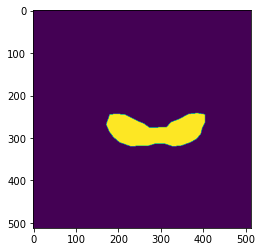

In [12]:
# split eye and face according to json file
import json

img_dir = "/home/hengfei/Desktop/research/D-NeRF/data/xgaze/images"
annotation_dir = "/home/hengfei/Desktop/research/D-NeRF/data/xgaze/annotions"

img_list = sorted(os.listdir(img_dir))
annotation_list = sorted(os.listdir(annotation_dir))[:14]

polygon_list = []
for json_file in annotation_list:
    with open(f"{annotation_dir}/{json_file}", "r") as f:
        load_dict = json.load(f)
    polygon = np.array(load_dict["shapes"][0]["points"], dtype=np.int32)
    polygon_list.append(polygon)
    mask = np.zeros((512, 512), dtype="uint8")
    # cv2.polylines(mask, polygon)
    cv2.fillPoly(mask, [polygon], 255)

    mask_dir = "/home/hengfei/Desktop/research/D-NeRF/data/xgaze/mask"
    if not os.path.exists(mask_dir):
        os.mkdir(mask_dir)
    json_str = json_file.split("_")
    mask_name = f"{json_str[1]}_mask.png"
    cv2.imwrite(f"{mask_dir}/{mask_name}", mask)

plt.imshow(mask)
    

In [12]:
mask_path = "/home/hengfei/Desktop/research/D-NeRF/data/xgaze/mask/cam00_mask.png"
mask = cv2.imread(mask_path)
mask.max()

255

In [ ]:
# check face landmarks in xgaze
csvPath = "/home/hengfei/Desktop/research/D-NeRF/data/subject0000/subject0000.csv"
df = pd.read_csv(csvPath, header=None)

landmarks = df.iloc[0,13:]
landmarks = landmarks.to_numpy()

img_path = "/home/hengfei/Desktop/research/datasets/subject0000/frame0000/cam00.JPG"
img = cv2.imread(img_path)
# for i in range(2):
#     cv2.circle(img, (int(landmarks[i*2]), int(landmarks[i*2+1])), 20, (255,0,0), -1)

cv2.imshow("img", img)

: 